In [108]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout, BatchNormalization
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score,mean_squared_error
from sklearn.model_selection import  train_test_split
from keras import backend as K
from keras import optimizers
import keras as k
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [109]:
#中冷后进气压力/进气量/ 中冷后进气温度/冷却水温度/ EGR阀开度/实测氧浓度/实测碳烟排放
data = pd.read_csv("../data/data_train.csv")
data.head()
data = data.dropna()
print(data.shape)

(149503, 11)


In [110]:
data.describe()

,NE,QFIN,PFIN,TFIN,PIM,AIR_FLOW,THA,THW,LEGR,CEXREAL,soot
count,149503.000000,149503.000000,149503.000000,149503.000000,149503.000000,1.495030e+05,149503.000000,149503.000000,149503.000000,149503.000000,149503.000000
mean,1267.187860,34.470280,77.709593,-0.398118,142.099270,3.220595e+02,47.706389,86.529215,26.890545,17.069971,1.354455
std,308.128849,37.490713,32.493292,1.673498,36.681588,1.541262e+02,2.715745,1.328715,13.581330,5.262956,1.256869
min,696.754822,-1.733852,30.207851,-2.849953,106.314072,1.400000e-08,31.174412,66.683716,0.000000,4.674084,-0.015000
25%,1144.967163,5.355454,53.260523,-1.670740,116.823456,2.233254e+02,46.508974,85.869404,19.915110,12.605148,0.625000
50%,1325.732422,18.747795,77.721054,-1.089020,126.246201,2.922540e+02,47.805603,86.558945,23.248041,18.143646,1.223000
75%,1512.458862,58.435289,100.883682,0.518604,162.959183,4.117750e+02,49.147144,87.241043,31.738495,21.310923,1.802000
max,2198.406006,137.415710,197.605286,6.716738,265.274353,9.227142e+02,57.733215,94.996307,91.331413,23.219999,50.917000


In [111]:
print('soot含量少于0g:',len(data[data['soot']<=0.0]))
print('soot含量大于20g:',len(data[data['soot']>=20.0]))      

soot含量少于0g: 5611
soot含量大于20g: 10


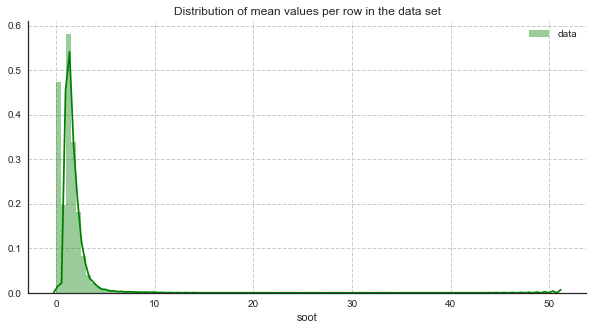

In [112]:

plt.figure(figsize=(10, 5))
plt.grid(linestyle="--")  # 设置背景网格线为虚线
ax = plt.gca()
ax.spines['top'].set_visible(False)  # 去掉上边框
ax.spines['right'].set_visible(False)  # 去掉右边框

features = data['soot']
plt.title("Distribution of mean values per row in the data set")
sns.distplot(features,color="green", kde=True,bins=100, label='data')
#sns.distplot(test_df[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

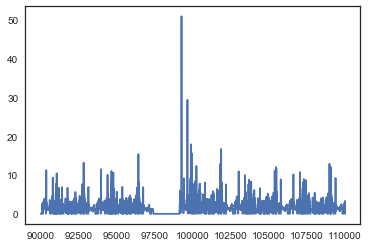

In [113]:
plt.plot(features[90000:110000])

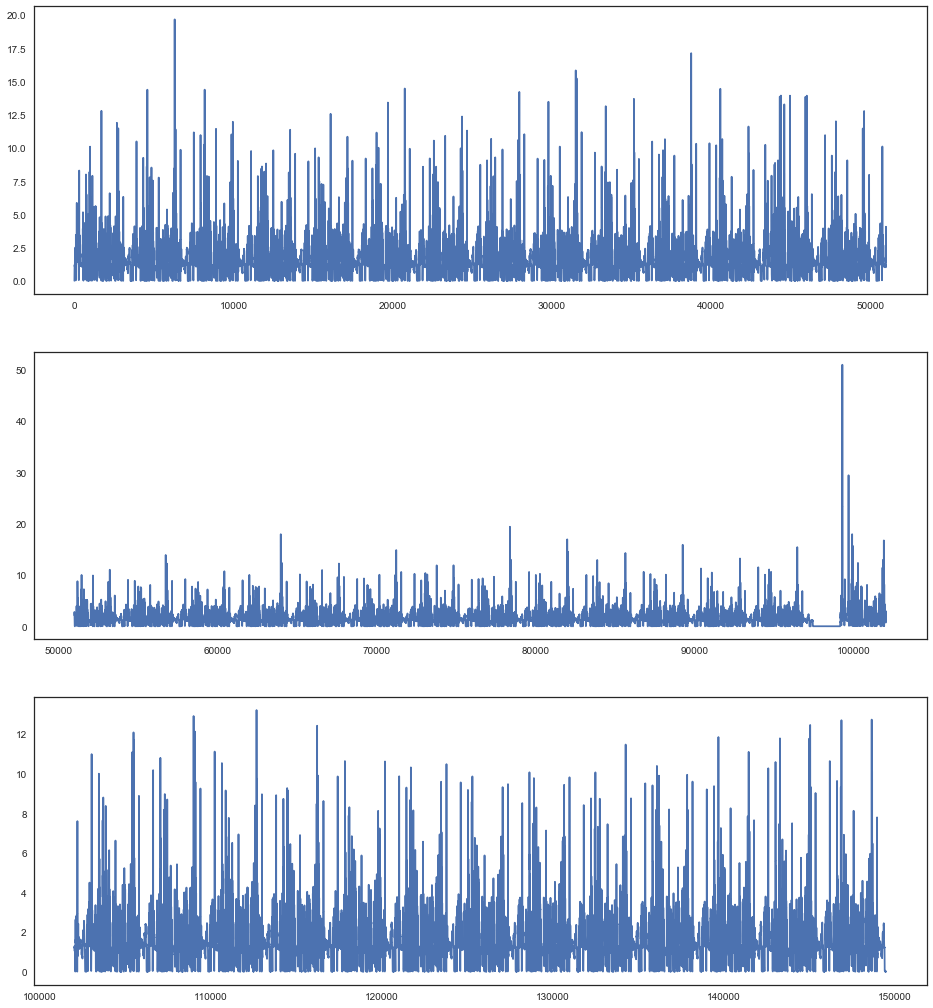

In [114]:
#90000个数据点到100000个数据点之间有数据异常，需要剔除
fig,ax=plt.subplots(3,1,figsize=(16,18))
for i in range(3):
    ax[i].plot(features[51000*i:51000*(i+1)])

                NE       QFIN        PFIN      TFIN         PIM    AIR_FLOW  \
99253  1442.559082  73.362961  107.111931  1.093732  175.331390  449.794207   
99254  1464.932983  78.786774  111.477715  1.426358  175.346909  476.138220   

             THA        THW       LEGR    CEXREAL    soot  
99253  34.504471  82.575302  33.284348   9.702115  50.917  
99254  34.526733  82.657455  26.511086  10.317282  50.917  


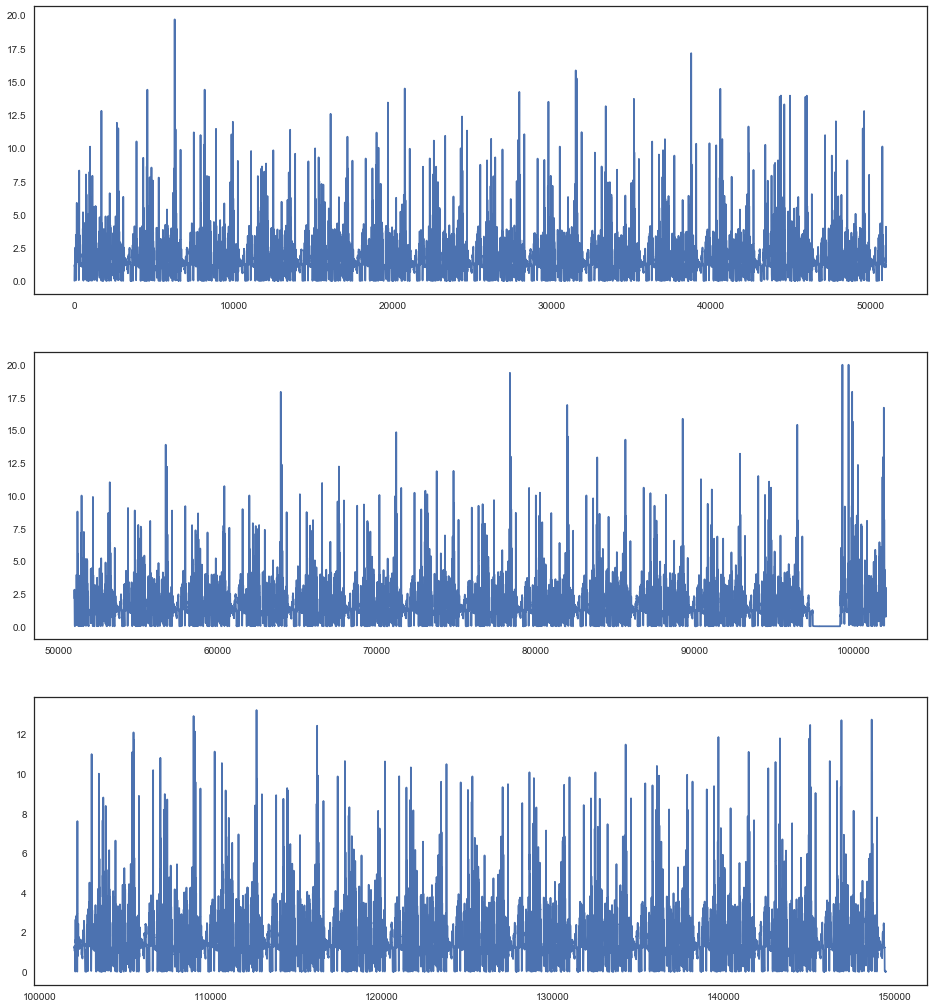

In [115]:
print(data[data['soot']>50])
f = lambda x : 20 if x>20 else x
data2 = data['soot'].map(f)
fig,ax=plt.subplots(3,1,figsize=(16,18))
for i in range(3):
    ax[i].plot(data2[51000*i:51000*(i+1)])

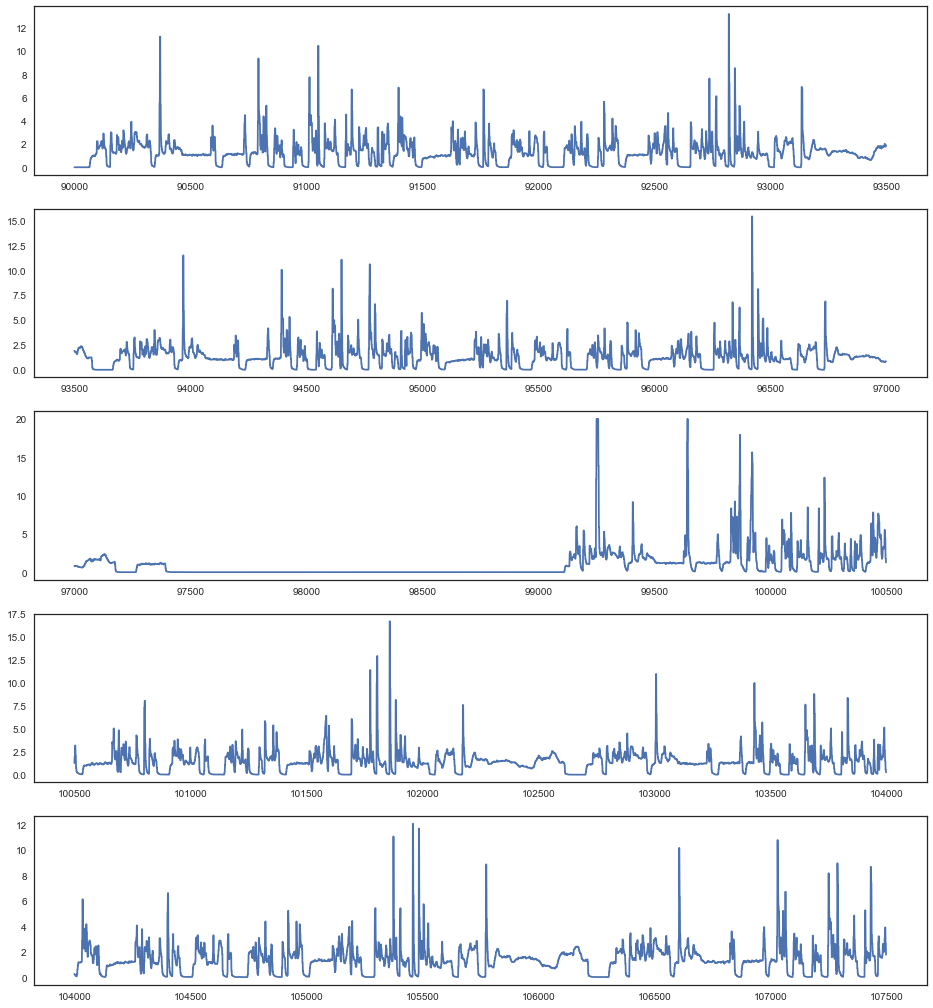

In [116]:
#
fig,ax=plt.subplots(5,1,figsize=(16,18))
for i in range(5):
    ax[i].plot(data2[90000+3500 * (i):(90000 + 3500 * (i+1))])

In [117]:
#将97000--100000范围的数据target修改
#print(len(data(data['soot'][97000:100000]) = 0))
data2[97000:100000] = -1

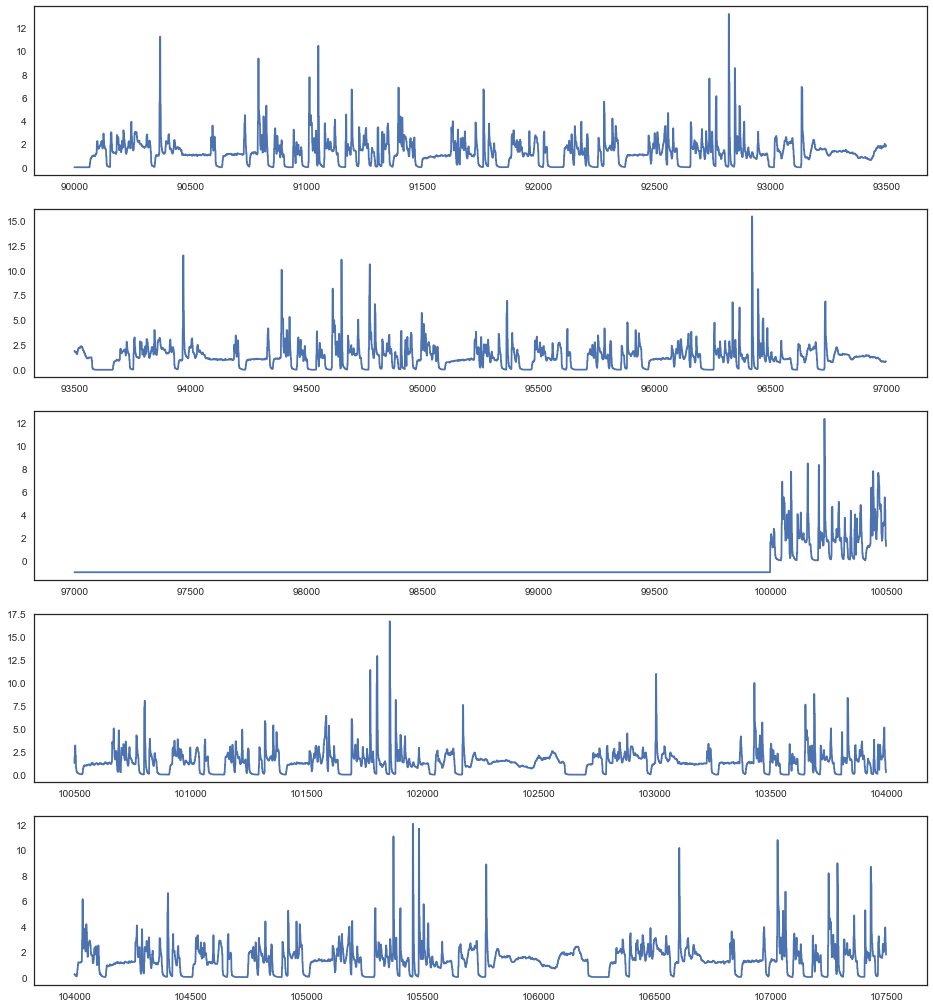

In [118]:
fig,ax=plt.subplots(5,1,figsize=(16,18))
for i in range(5):
    ax[i].plot(data2[90000+3500 * (i):(90000 + 3500 * (i+1))])

In [119]:
data['soot'][97000:100000] = -1
data.describe()

,NE,QFIN,PFIN,TFIN,PIM,AIR_FLOW,THA,THW,LEGR,CEXREAL,soot
count,149503.000000,149503.000000,149503.000000,149503.000000,149503.000000,1.495030e+05,149503.000000,149503.000000,149503.000000,149503.000000,149503.000000
mean,1267.187860,34.470280,77.709593,-0.398118,142.099270,3.220595e+02,47.706389,86.529215,26.890545,17.069971,1.316886
std,308.128849,37.490713,32.493292,1.673498,36.681588,1.541262e+02,2.715745,1.328715,13.581330,5.262956,1.241563
min,696.754822,-1.733852,30.207851,-2.849953,106.314072,1.400000e-08,31.174412,66.683716,0.000000,4.674084,-1.000000
25%,1144.967163,5.355454,53.260523,-1.670740,116.823456,2.233254e+02,46.508974,85.869404,19.915110,12.605148,0.519000
50%,1325.732422,18.747795,77.721054,-1.089020,126.246201,2.922540e+02,47.805603,86.558945,23.248041,18.143646,1.217000
75%,1512.458862,58.435289,100.883682,0.518604,162.959183,4.117750e+02,49.147144,87.241043,31.738495,21.310923,1.795000
max,2198.406006,137.415710,197.605286,6.716738,265.274353,9.227142e+02,57.733215,94.996307,91.331413,23.219999,19.672000


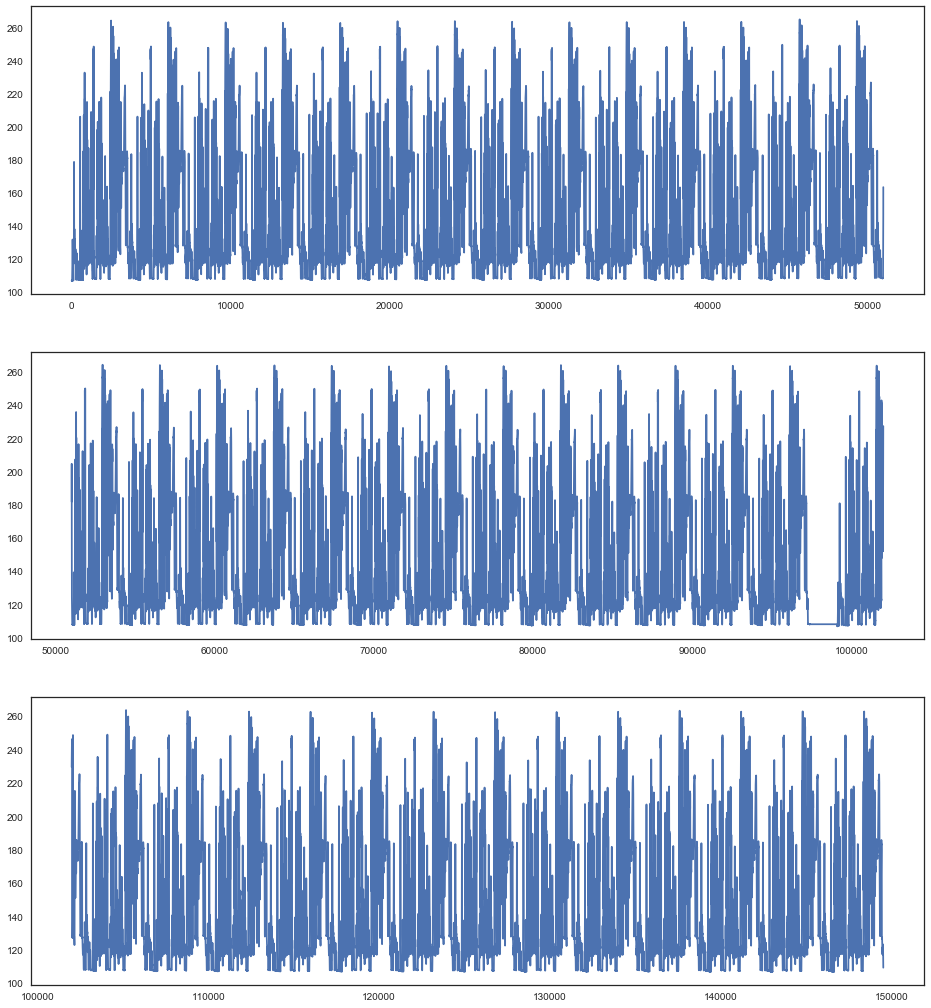

In [120]:
#观察其他标签的变化，是否保持一致??
#(1)PIM
data3 = data['PIM']
fig,ax=plt.subplots(3,1,figsize=(16,18))
for i in range(3):
    ax[i].plot(data3[51000*i:51000*(i+1)])

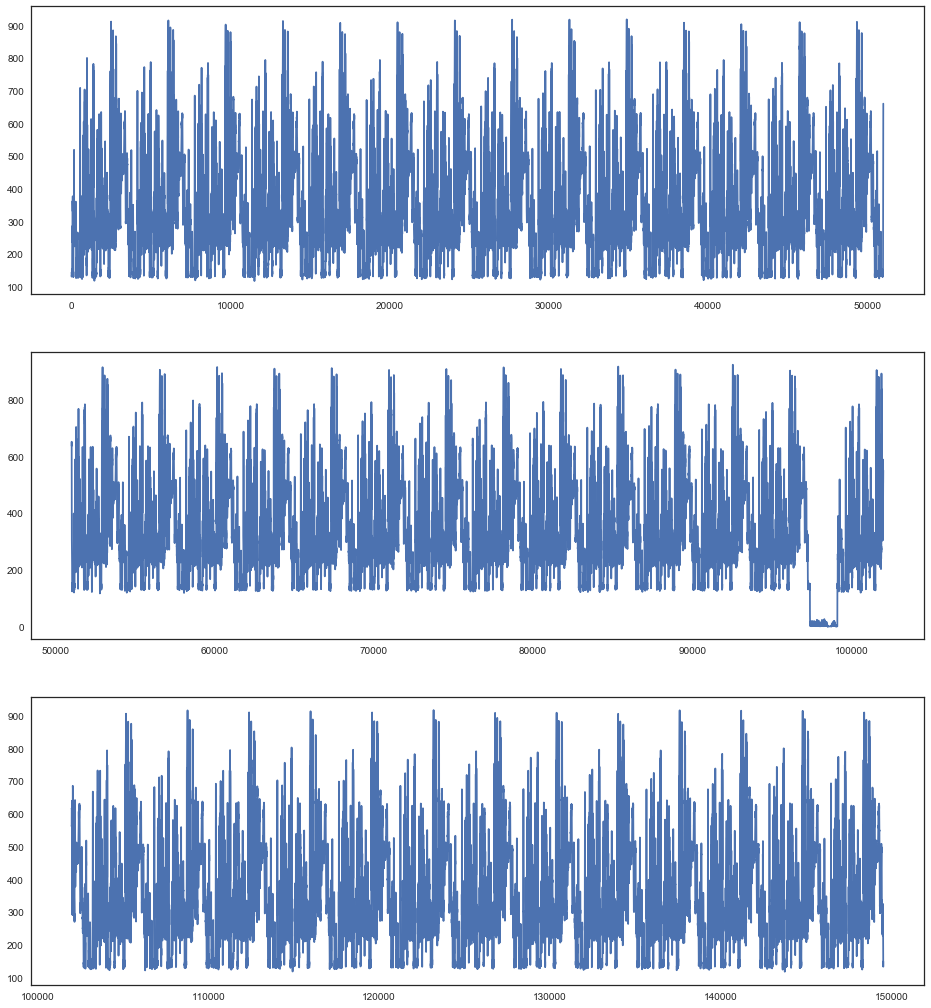

In [121]:
data4 = data['AIR_FLOW']
fig,ax=plt.subplots(3,1,figsize=(16,18))
for i in range(3):
    ax[i].plot(data4[51000*i:51000*(i+1)])

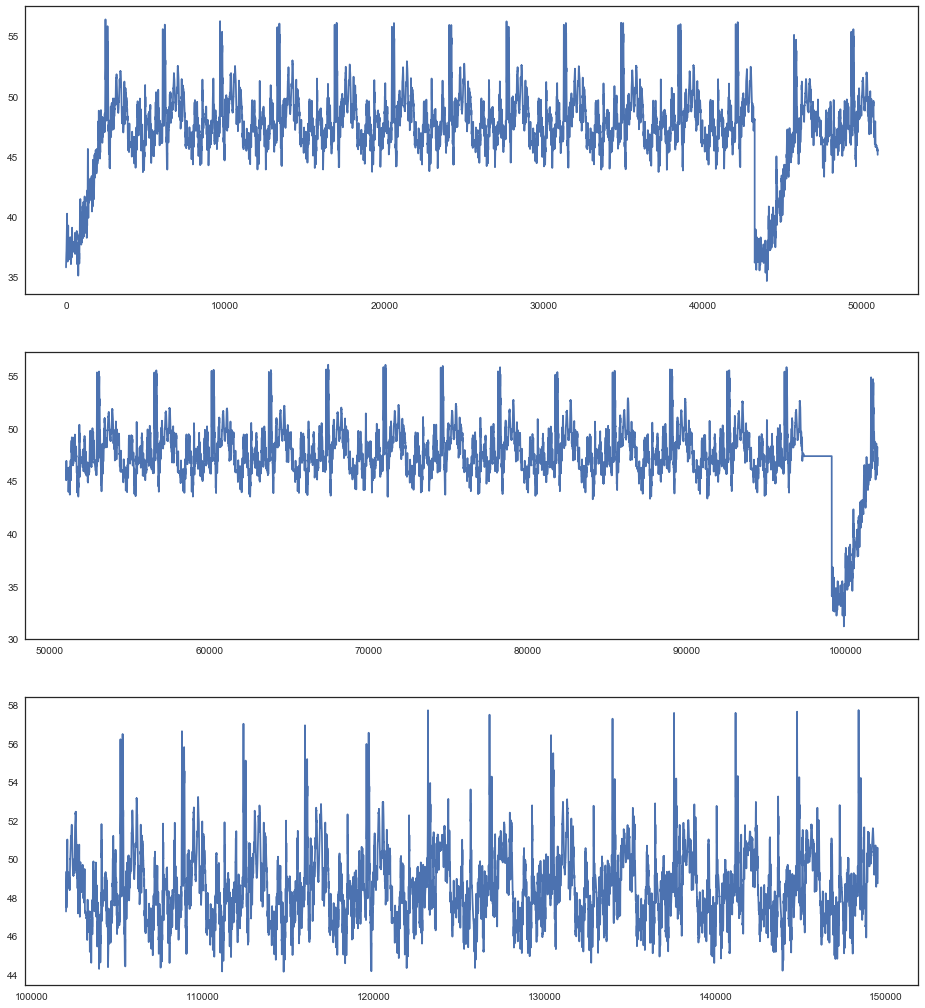

In [122]:
data5 = data['THA']
fig,ax=plt.subplots(3,1,figsize=(16,18))
for i in range(3):
    ax[i].plot(data5[51000*i:51000*(i+1)])

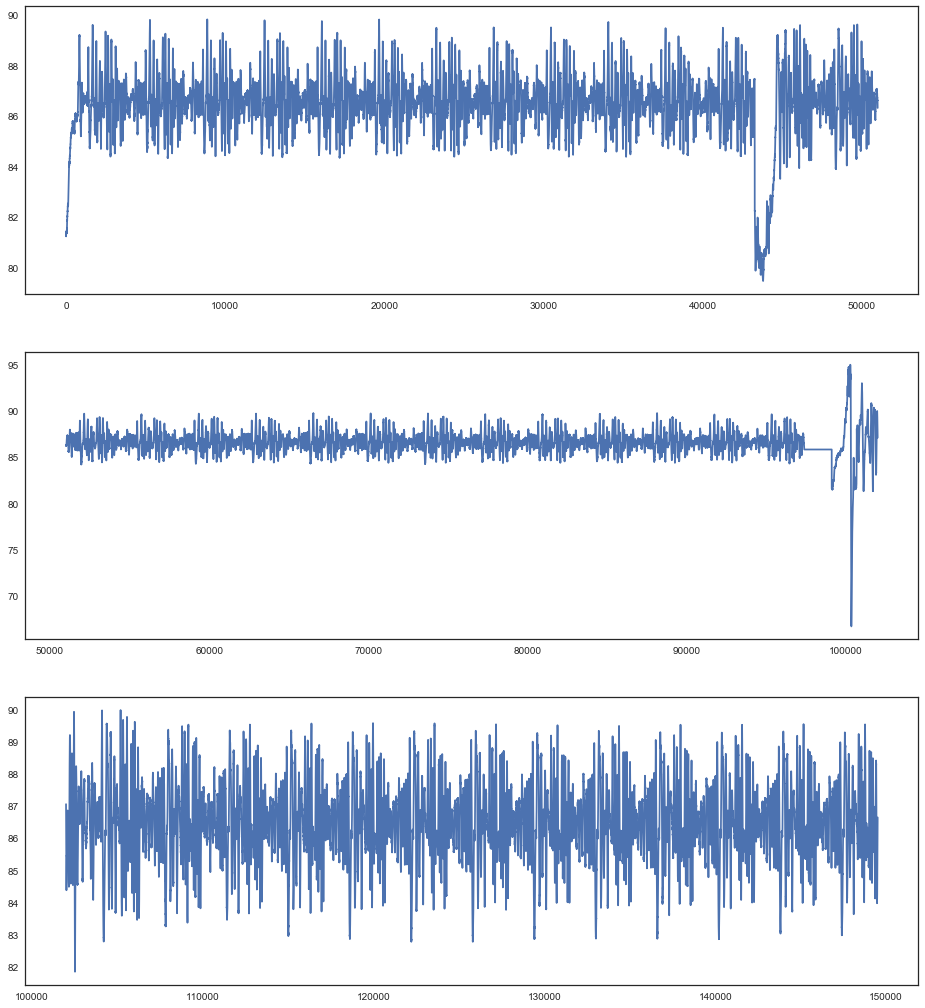

In [123]:
data6 = data['THW']
fig,ax=plt.subplots(3,1,figsize=(16,18))
for i in range(3):
    ax[i].plot(data6[51000*i:51000*(i+1)])

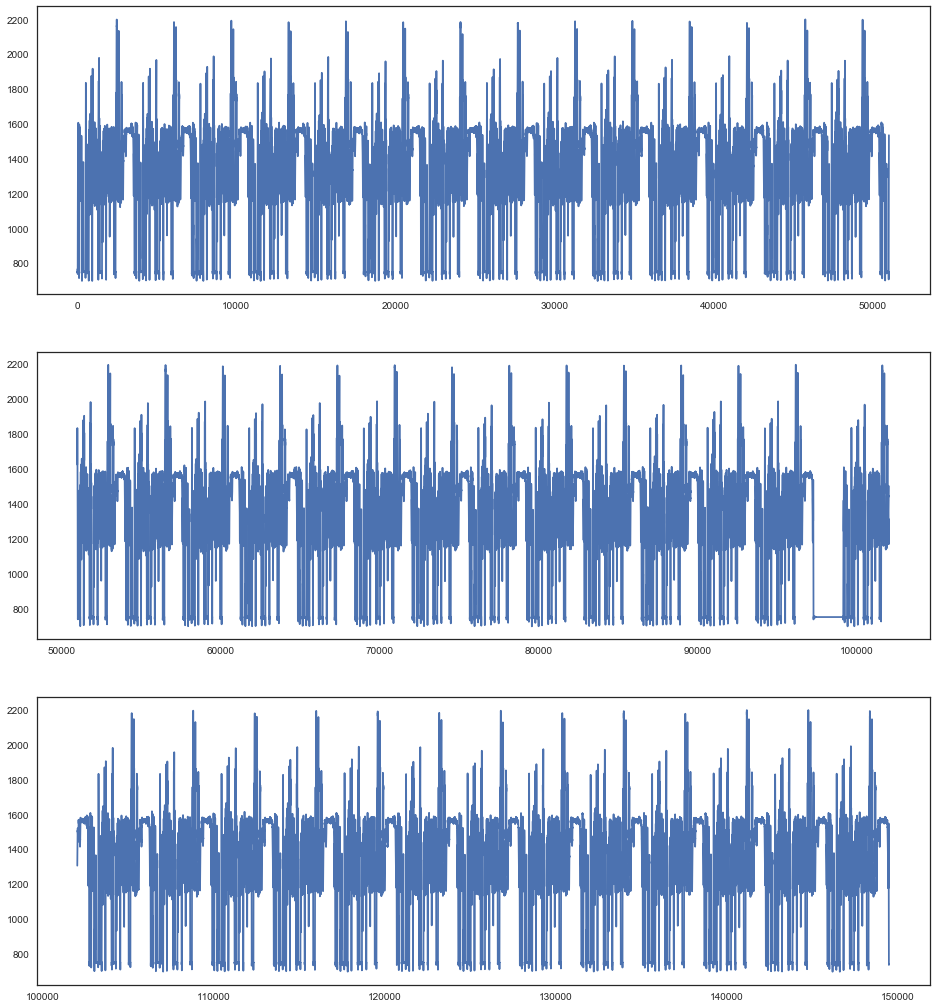

In [124]:
data7 = data['NE']
fig,ax=plt.subplots(3,1,figsize=(16,18))
for i in range(3):
    ax[i].plot(data7[51000*i:51000*(i+1)])

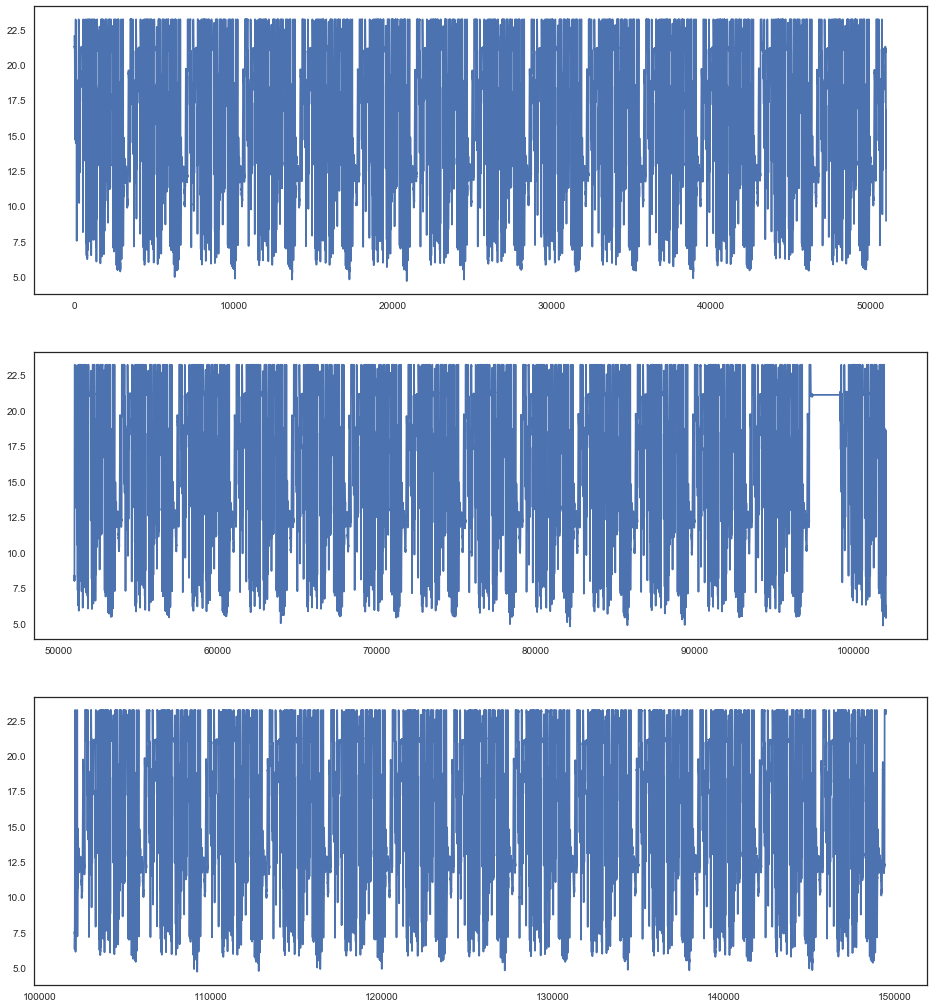

In [125]:
data8 = data['CEXREAL']
fig,ax=plt.subplots(3,1,figsize=(16,18))
for i in range(3):
    ax[i].plot(data8[51000*i:51000*(i+1)])

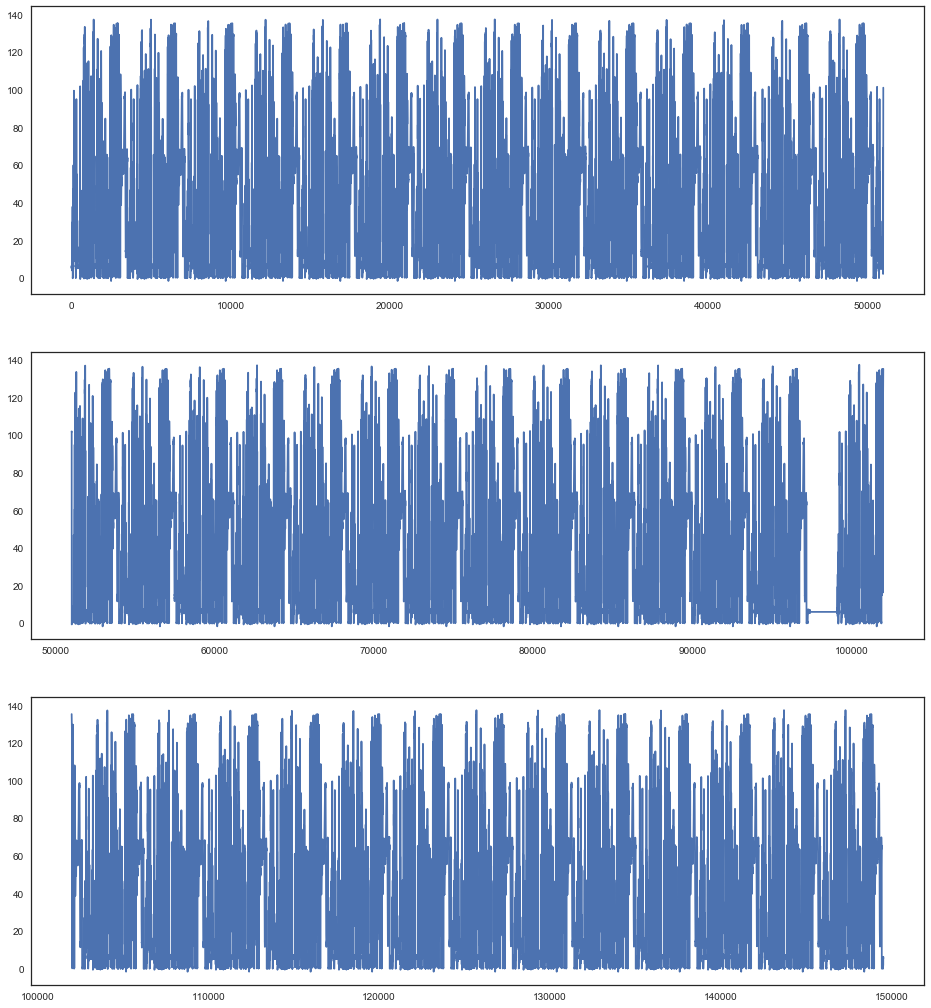

In [126]:
data8 = data['QFIN']
fig,ax=plt.subplots(3,1,figsize=(16,18))
for i in range(3):
    ax[i].plot(data8[51000*i:51000*(i+1)])

In [127]:
#删除97000--100000范围的数据
data['soot'][97000:100000] = -1
data_la = data[data['soot'] != -1]
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
#f = lambda x : 20 if x>20 else x
#data2 = data['soot'].map(f)
data_la['soot'] = data_la['soot'].apply( lambda x: 0.1 if x<0.2 else x)
#data_la['soot'] = data_la['soot'].apply( lambda x: 20 if x>20 else x)
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
#data_la['soot'] = data_la['soot'].apply( lambda x: 0.2 if (x < 0.3) & (x >0.1) else x)  
#data_la['soot'] = data_la['soot'].apply( lambda x: 0.15 if x<0.3 else x)

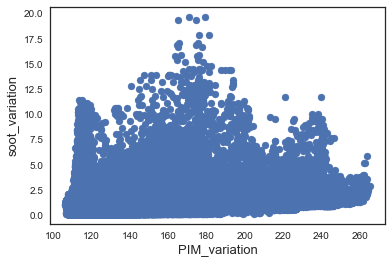

In [128]:
#观察各特征标签与soot碳载量之间的关系
#(1)中冷后进气压力
fig, ax = plt.subplots()
ax.scatter(x = data_la['PIM'], y = data_la['soot'])
plt.ylabel('soot_variation', fontsize=13)
plt.xlabel('PIM_variation', fontsize=13)
plt.show()

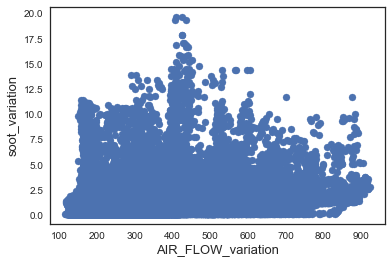

In [129]:
#(2)进气量
fig, ax = plt.subplots()
ax.scatter(x = data_la['AIR_FLOW'], y = data_la['soot'])
plt.ylabel('soot_variation', fontsize=13)
plt.xlabel('AIR_FLOW_variation', fontsize=13)
plt.show()

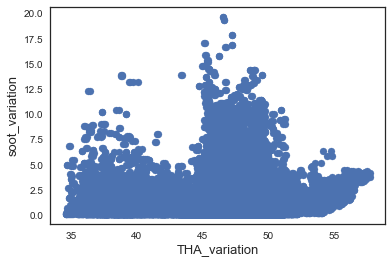

In [130]:
#(3)中冷后进气温度
fig, ax = plt.subplots()
ax.scatter(x = data_la['THA'], y = data_la['soot'])
plt.ylabel('soot_variation', fontsize=13)
plt.xlabel('THA_variation', fontsize=13)
plt.show()

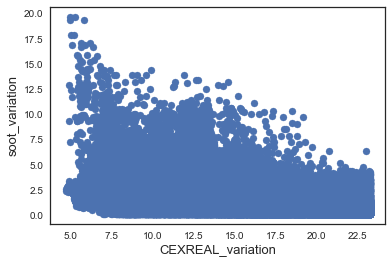

In [131]:
#(4)排气氧浓度
fig, ax = plt.subplots()
ax.scatter(x = data_la['CEXREAL'], y = data_la['soot'])
plt.ylabel('soot_variation', fontsize=13)
plt.xlabel('CEXREAL_variation', fontsize=13)
plt.show()

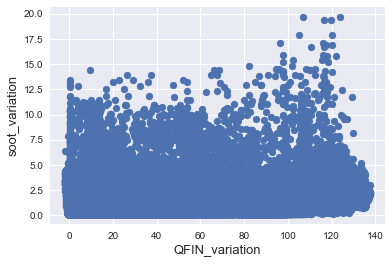

In [24]:
#(5)循环喷油量
fig, ax = plt.subplots()
ax.scatter(x = data_la['QFIN'], y = data_la['soot'])
plt.ylabel('soot_variation', fontsize=13)
plt.xlabel('QFIN_variation', fontsize=13)
plt.show()

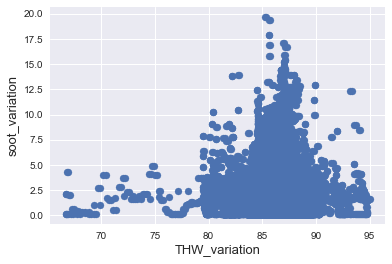

In [25]:
#(6)冷却水温度
fig, ax = plt.subplots()
ax.scatter(x = data_la['THW'], y = data_la['soot'])
plt.ylabel('soot_variation', fontsize=13)
plt.xlabel('THW_variation', fontsize=13)
plt.show()

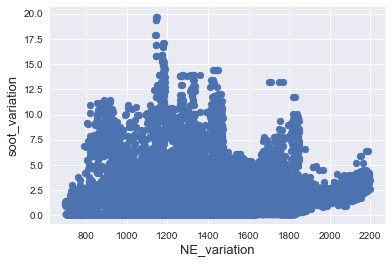

In [26]:
#(7)发动机转速
fig, ax = plt.subplots()
ax.scatter(x = data_la['NE'], y = data_la['soot'])
plt.ylabel('soot_variation', fontsize=13)
plt.xlabel('NE_variation', fontsize=13)
plt.show()


 mu = 1.32 and sigma = 1.24



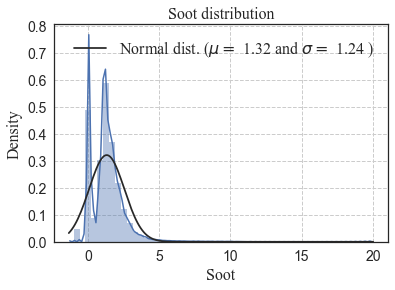

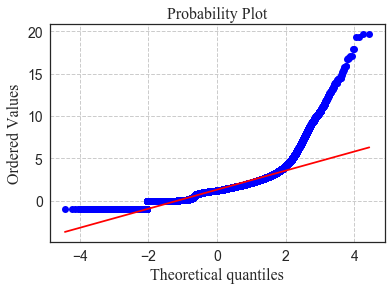

In [132]:
from scipy import stats
from scipy.stats import norm, skew
sns.set_style('white')
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
data_la['soot'] = np.log1p(data_la['soot'])

#Check the new distribution 
sns.distplot(data['soot'] , fit=norm,rug_kws = {'color':'g','lw':2,'alpha':0.5} , 
             kde_kws={ "lw": 1.5, 'linestyle':'-'});

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['soot'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best',prop = font)
plt.ylabel('Density',font)
plt.xlabel('Soot',font)
plt.xticks(fontsize=14,fontweight='normal') #默认字体大小为10
plt.yticks(fontsize=14,fontweight='normal')
plt.grid(linestyle = '--')     # 添加网格线
plt.title('Soot distribution',font)
plt.savefig('1.jpg',dpi=600, bbox_inches = 'tight')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['soot'], plot=plt)
plt.ylabel('Ordered Values',font)
plt.xlabel('Theoretical quantiles',font)
plt.xticks(fontsize=14,fontweight='normal') #默认字体大小为10
plt.yticks(fontsize=14,fontweight='normal')
plt.grid(linestyle = '--')     # 添加网格线
plt.title('Probability Plot',font)
plt.savefig('2.jpg',dpi=600, bbox_inches = 'tight')
plt.show()



 mu = 0.53 and sigma = 0.26



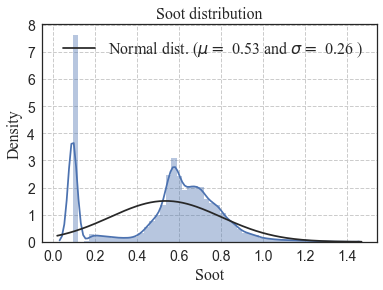

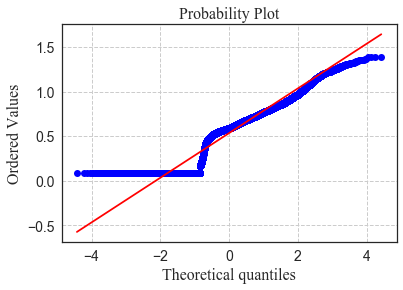

In [133]:
data_la['soot'] = np.log1p(data_la['soot'])

#Check the new distribution 
sns.distplot(data_la['soot'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data_la['soot'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best',prop = font)
plt.ylabel('Density',font)
plt.xlabel('Soot',font)
plt.xticks(fontsize=14,fontweight='normal') #默认字体大小为10
plt.yticks(fontsize=14,fontweight='normal')
plt.grid(linestyle = '--')     # 添加网格线
plt.title('Soot distribution',font)
plt.savefig('3.jpg',dpi=600, bbox_inches = 'tight')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data_la['soot'], plot=plt)
plt.ylabel('Ordered Values',font)
plt.xlabel('Theoretical quantiles',font)
plt.xticks(fontsize=14,fontweight='normal') #默认字体大小为10
plt.yticks(fontsize=14,fontweight='normal')
plt.grid(linestyle = '--')     # 添加网格线
plt.title('Probability Plot',font)
plt.savefig('4.jpg',dpi=600, bbox_inches = 'tight')
plt.show()

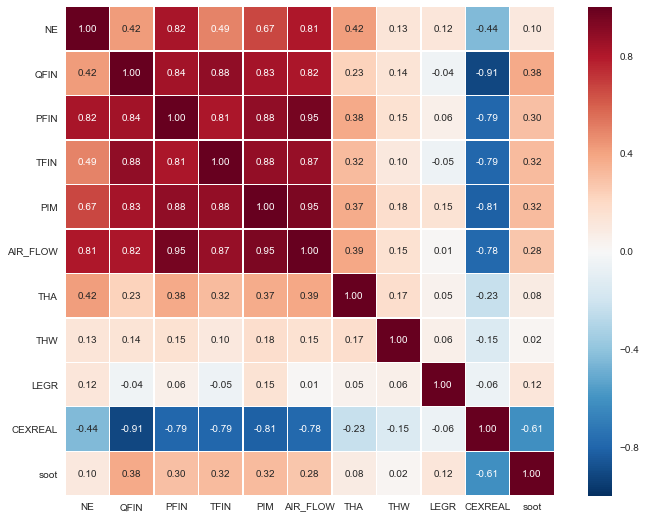

In [134]:
#Correlation map to see how features are correlated with SalePrice
corrmat = data_la.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, square=True,annot=True,fmt= ".2f",linewidths= 0.3)
plt.savefig('5.jpg',dpi = 600, bbox_inches = 'tight' )